The cell below removes the annoying app bar thing at the bottom of a notebook.

In [1]:
%%javascript
$('.nbp-app-bar').toggle()

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from datetime import datetime
import calendar
import sqlite3
import seaborn as sns
#import pysal as ps
#from pysal.contrib.viz import mapping as maps
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomTreesEmbedding, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_curve
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA


%matplotlib inline

The cell below makes it so pandas will show me all the columns.

In [3]:
pd.set_option('display.max_columns', 40)

The below cell loads the spatialite extention to sqlite. I got the code from the spatialite mailing list
https://groups.google.com/d/msg/spatialite-users/o0jUwMUqx_g/OEat2JTUAAAJ
I can get it to work without geopandas. With geopandas imported it kills the ipython kernel within seconds. Ironic! Without one, the other is useless.

In [4]:
#conn = sqlite3.connect(':memory:') 
#conn.enable_load_extension(True) 
#conn.execute("SELECT load_extension('mod_spatialite')") 

The below code for importing all the sql data came from: https://www.dataquest.io/blog/python-pandas-databases/

In [4]:
conn = sqlite3.connect("./data/FPA_FOD_20170508.sqlite")

In [6]:
#this is if you want to read the data in as tuples

#cur = conn.cursor()
#cur.execute("SELECT * FROM fires;")
#results = cur.fetchall()

In [5]:
df_all = pd.read_sql_query("SELECT * FROM fires;", conn)
#this grabs the whole db and puts it into a df using the sqlite3.Connection

In [6]:
df_all.shape

(1880465, 39)

In [7]:
df_all.head(2)

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,LOCAL_FIRE_REPORT_ID,LOCAL_INCIDENT_ID,FIRE_CODE,FIRE_NAME,ICS_209_INCIDENT_NUMBER,ICS_209_NAME,MTBS_ID,MTBS_FIRE_NAME,COMPLEX_NAME,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,Plumas National Forest,1,PNF-47,BJ8K,FOUNTAIN,None,None,None,None,None,2005,2453403.5,33,1300,9.0,Miscellaneous,2453403.5,33.0,1730,0.10,A,40.036944,-121.005833,5.0,USFS,CA,63,063,Plumas,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...
1,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,13,13,AAC0,PIGEON,None,None,None,None,None,2004,2453137.5,133,0845,1.0,Lightning,2453137.5,133.0,1530,0.25,A,38.933056,-120.404444,5.0,USFS,CA,61,061,Placer,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...


Since pandas can't handle the geometry information the Shape column is useless anyway, I'm going to drop it. It lives on in the original sqlite db.

In [8]:
df_all.drop(['Shape'], axis=1, inplace=True)

In [9]:
df_all.columns

Index(['OBJECTID', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM',
       'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
       'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
       'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
       'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME',
       'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME',
       'COMPLEX_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY',
       'DISCOVERY_TIME', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'CONT_DATE',
       'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE',
       'LONGITUDE', 'OWNER_CODE', 'OWNER_DESCR', 'STATE', 'COUNTY',
       'FIPS_CODE', 'FIPS_NAME'],
      dtype='object')

In [10]:
df_all.STAT_CAUSE_DESCR.unique()

array(['Miscellaneous', 'Lightning', 'Debris Burning', 'Campfire',
       'Equipment Use', 'Arson', 'Children', 'Railroad', 'Smoking',
       'Powerline', 'Structure', 'Fireworks', 'Missing/Undefined'],
      dtype=object)

There are entries in my target column that I can't use so I am dropping them.

In [11]:
df_all.drop(df_all[df_all['STAT_CAUSE_DESCR'] == 'Missing/Undefined'].index, inplace=True)

In [12]:
df_all.shape

(1713742, 38)

In [13]:
df_all.dtypes

OBJECTID                        int64
FOD_ID                          int64
FPA_ID                         object
SOURCE_SYSTEM_TYPE             object
SOURCE_SYSTEM                  object
NWCG_REPORTING_AGENCY          object
NWCG_REPORTING_UNIT_ID         object
NWCG_REPORTING_UNIT_NAME       object
SOURCE_REPORTING_UNIT          object
SOURCE_REPORTING_UNIT_NAME     object
LOCAL_FIRE_REPORT_ID           object
LOCAL_INCIDENT_ID              object
FIRE_CODE                      object
FIRE_NAME                      object
ICS_209_INCIDENT_NUMBER        object
ICS_209_NAME                   object
MTBS_ID                        object
MTBS_FIRE_NAME                 object
COMPLEX_NAME                   object
FIRE_YEAR                       int64
DISCOVERY_DATE                float64
DISCOVERY_DOY                   int64
DISCOVERY_TIME                 object
STAT_CAUSE_CODE               float64
STAT_CAUSE_DESCR               object
CONT_DATE                     float64
CONT_DOY    

In [14]:
df_all.isnull().sum()

OBJECTID                            0
FOD_ID                              0
FPA_ID                              0
SOURCE_SYSTEM_TYPE                  0
SOURCE_SYSTEM                       0
NWCG_REPORTING_AGENCY               0
NWCG_REPORTING_UNIT_ID              0
NWCG_REPORTING_UNIT_NAME            0
SOURCE_REPORTING_UNIT               0
SOURCE_REPORTING_UNIT_NAME          0
LOCAL_FIRE_REPORT_ID          1297372
LOCAL_INCIDENT_ID              705847
FIRE_CODE                     1396084
FIRE_NAME                      839288
ICS_209_INCIDENT_NUMBER       1691038
ICS_209_NAME                  1691038
MTBS_ID                       1703584
MTBS_FIRE_NAME                1703584
COMPLEX_NAME                  1708655
FIRE_YEAR                           0
DISCOVERY_DATE                      0
DISCOVERY_DOY                       0
DISCOVERY_TIME                 770477
STAT_CAUSE_CODE                     0
STAT_CAUSE_DESCR                    0
CONT_DATE                      796359
CONT_DOY    

I'm going to create a new df, df_pred, by dropping columns from the FPA_FOD data. I'm going to read that into a csv so I have it for later, and then stop using the full set. I will keep the full set on my SSD, of course. I am making these decisions based on the data atlas located here: https://www.kaggle.com/davideanastasia/contour-map-of-us-wildfire-dataset/data

In [15]:
df_all['FIRE_CODE'].value_counts()

D44Z    9451
5555    5144
D5GJ    3459
0001    3329
0000    1928
2300    1892
EKV3    1032
4700    1003
EKW0     938
0100     904
EKT5     883
5900     833
EKV0     756
EK2R     729
7000     721
EKV5     703
EK2D     690
EK3D     666
EK2N     660
EKV6     647
EK2A     624
EKT4     614
EK2B     585
EK2Q     551
7500     537
EN0A     533
EK2F     513
EKW2     504
EKS5     495
EKT1     493
        ... 
BT57       1
JH98       1
H1D5       1
DB84       1
HV6U       1
HF27       1
DU6S       1
D5P9       1
DL9S       1
D3Y8       1
GH39       1
GZR0       1
FV0S       1
DX8C       1
ED7L       1
CA2F       1
HXZ1       1
H0FZ       1
FC9Y       1
E36Z       1
D7NP       1
JR07       1
HD94       1
CLM3       1
G8E0       1
FMX4       1
EU9J       1
H59G       1
F4FC       1
H1AC       1
Name: FIRE_CODE, Length: 166669, dtype: int64

I'm going to drop features that I don't care about and then do feature engineering.

In [16]:
df_all = df_all.drop(['OBJECTID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM',
                  'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
                  'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
                  'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
                  'LOCAL_INCIDENT_ID', 'FIRE_NAME',
                  'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME',
                  'COMPLEX_NAME', 'FIRE_YEAR', 'DISCOVERY_TIME', 
                  'STAT_CAUSE_CODE', 'CONT_TIME', 
                  'FIRE_SIZE_CLASS', 'LATITUDE', 'LONGITUDE', 'OWNER_CODE', 
                  'OWNER_DESCR', 'COUNTY', 'FIPS_NAME'], axis=1)

In [17]:
df_all.shape

(1713742, 10)

In [18]:
df_all.head(3)

,FOD_ID,FIRE_CODE,DISCOVERY_DATE,DISCOVERY_DOY,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,FIRE_SIZE,STATE,FIPS_CODE
0,1,BJ8K,2453403.5,33,Miscellaneous,2453403.5,33.0,0.10,CA,063
1,2,AAC0,2453137.5,133,Lightning,2453137.5,133.0,0.25,CA,061
2,3,A32W,2453156.5,152,Debris Burning,2453156.5,152.0,0.10,CA,017


Time for feature engineering.

The 2 columns with the dates for discovery and containment are in the Julian format so I will have to convert them into gregorian timestamps and then engineer a duration. I do think day of year discovered will have some predictive power and will keep that column. I will also engineer month and a day-of-week discovered features.

In [19]:
df_all['START_DATE'] = pd.to_datetime(df_all['DISCOVERY_DATE'], unit='D', infer_datetime_format=True, origin='julian')

In [20]:
df_all['END_DATE'] = pd.to_datetime(df_all['CONT_DATE'], unit='D', infer_datetime_format=True, origin='julian')

In [21]:
df_all.head(2)

,FOD_ID,FIRE_CODE,DISCOVERY_DATE,DISCOVERY_DOY,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,FIRE_SIZE,STATE,FIPS_CODE,START_DATE,END_DATE
0,1,BJ8K,2453403.5,33,Miscellaneous,2453403.5,33.0,0.10,CA,063,2005-02-02,2005-02-02
1,2,AAC0,2453137.5,133,Lightning,2453137.5,133.0,0.25,CA,061,2004-05-12,2004-05-12


In [22]:
df_all.drop(['DISCOVERY_DATE', 'CONT_DATE'], axis=1, inplace=True)

In [23]:
df_all.head(3)

,FOD_ID,FIRE_CODE,DISCOVERY_DOY,STAT_CAUSE_DESCR,CONT_DOY,FIRE_SIZE,STATE,FIPS_CODE,START_DATE,END_DATE
0,1,BJ8K,33,Miscellaneous,33.0,0.10,CA,063,2005-02-02,2005-02-02
1,2,AAC0,133,Lightning,133.0,0.25,CA,061,2004-05-12,2004-05-12
2,3,A32W,152,Debris Burning,152.0,0.10,CA,017,2004-05-31,2004-05-31


In [24]:
df_all['BURN_TIME'] = (df_all['END_DATE'] - df_all['START_DATE']).astype('timedelta64[D]')

In [25]:
df_all['MONTH'] = pd.DatetimeIndex(df_all['START_DATE']).month

In [26]:
df_all['DOW'] = pd.DatetimeIndex(df_all['START_DATE']).weekday_name

In [27]:
df_all.head(3)

,FOD_ID,FIRE_CODE,DISCOVERY_DOY,STAT_CAUSE_DESCR,CONT_DOY,FIRE_SIZE,STATE,FIPS_CODE,START_DATE,END_DATE,BURN_TIME,MONTH,DOW
0,1,BJ8K,33,Miscellaneous,33.0,0.10,CA,063,2005-02-02,2005-02-02,0.0,2,Wednesday
1,2,AAC0,133,Lightning,133.0,0.25,CA,061,2004-05-12,2004-05-12,0.0,5,Wednesday
2,3,A32W,152,Debris Burning,152.0,0.10,CA,017,2004-05-31,2004-05-31,0.0,5,Monday


In [28]:
df_all.drop(['CONT_DOY'], axis=1, inplace=True)

In [29]:
df_all.drop(['START_DATE', 'END_DATE'], axis=1, inplace=True)

In [30]:
df_all.head(3)

,FOD_ID,FIRE_CODE,DISCOVERY_DOY,STAT_CAUSE_DESCR,FIRE_SIZE,STATE,FIPS_CODE,BURN_TIME,MONTH,DOW
0,1,BJ8K,33,Miscellaneous,0.10,CA,063,0.0,2,Wednesday
1,2,AAC0,133,Lightning,0.25,CA,061,0.0,5,Wednesday
2,3,A32W,152,Debris Burning,0.10,CA,017,0.0,5,Monday


In [31]:
df_all.drop(['FOD_ID'], axis=1, inplace=True)

In [32]:
df_all.head()

,FIRE_CODE,DISCOVERY_DOY,STAT_CAUSE_DESCR,FIRE_SIZE,STATE,FIPS_CODE,BURN_TIME,MONTH,DOW
0,BJ8K,33,Miscellaneous,0.10,CA,063,0.0,2,Wednesday
1,AAC0,133,Lightning,0.25,CA,061,0.0,5,Wednesday
2,A32W,152,Debris Burning,0.10,CA,017,0.0,5,Monday
3,None,180,Lightning,0.10,CA,003,5.0,6,Monday
4,None,180,Lightning,0.10,CA,003,5.0,6,Monday


In [33]:
df_all['BURN_TIME'].isnull().sum()

796359

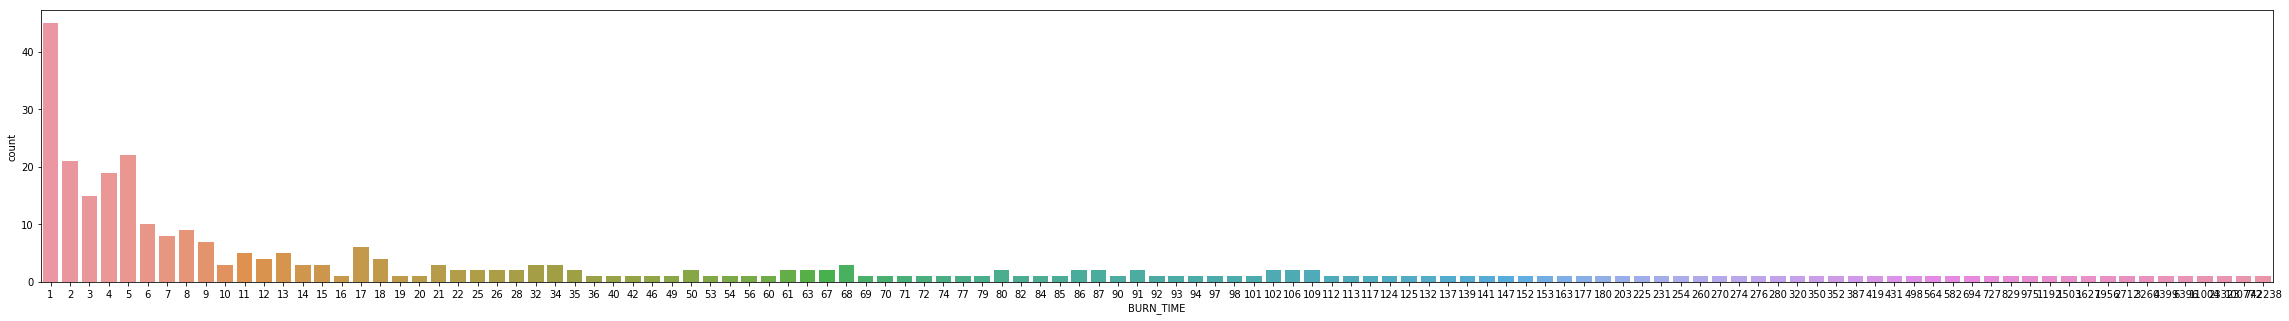

In [34]:
fig, ax = plt.subplots(figsize=(40,5))
sns.countplot(x=df_all['BURN_TIME'].value_counts(), data=df_all)

I'm going to make a new column to use as my target, "Arson". If the cause was arson the value will be 1, else 0.

In [35]:
def make_arson(dataframe):
    if dataframe['STAT_CAUSE_DESCR'] == 'Arson':
        val = 1
    else:
        val = 0
    return val

In [36]:
df_all['ARSON'] = df_all.apply(make_arson, axis=1)

In [37]:
df_all.head(3)

,FIRE_CODE,DISCOVERY_DOY,STAT_CAUSE_DESCR,FIRE_SIZE,STATE,FIPS_CODE,BURN_TIME,MONTH,DOW,ARSON
0,BJ8K,33,Miscellaneous,0.10,CA,063,0.0,2,Wednesday,0
1,AAC0,133,Lightning,0.25,CA,061,0.0,5,Wednesday,0
2,A32W,152,Debris Burning,0.10,CA,017,0.0,5,Monday,0


Now That I've made the target column for arson I can drop the original column.

In [38]:
df_all.drop(['STAT_CAUSE_DESCR'], axis=1, inplace=True)

In [39]:
df_all.ARSON.value_counts()

0    1432287
1     281455
Name: ARSON, dtype: int64

In [40]:
281455/1713742

0.164234172938517

16.42% of these fires were started by arsonists! Crazy. Also: that's a pretty unbalanced class.

I wonder if that would change significantly if I just dropped the rows with a null in burn time?

In [41]:
df_nonan = df_all.drop(df_all[df_all.BURN_TIME.isnull() == True].index)

In [42]:
df_nonan.shape

(917383, 9)

In [43]:
df_nonan.ARSON.value_counts()

0    771131
1    146252
Name: ARSON, dtype: int64

In [44]:
146252/917383

0.15942305449305252

That's too big of a change to just drop them.

In [45]:
df_all['FIRE_CODE'].isnull().sum()

1396084

I was hoping to keep that in but if a majority of the cells are nulls then it doesn't make sense.

In [46]:
df_all.drop(['FIRE_CODE'], axis=1, inplace=True)

In [47]:
df_all.head(3)

,DISCOVERY_DOY,FIRE_SIZE,STATE,FIPS_CODE,BURN_TIME,MONTH,DOW,ARSON
0,33,0.10,CA,063,0.0,2,Wednesday,0
1,133,0.25,CA,061,0.0,5,Wednesday,0
2,152,0.10,CA,017,0.0,5,Monday,0


In [48]:
df_all.dtypes

DISCOVERY_DOY      int64
FIRE_SIZE        float64
STATE             object
FIPS_CODE         object
BURN_TIME        float64
MONTH              int64
DOW               object
ARSON              int64
dtype: object

In [49]:
df_all['MONTH'] = df_all['MONTH'].apply(lambda x: calendar.month_name[x])

In [50]:
df_all.head(2)

,DISCOVERY_DOY,FIRE_SIZE,STATE,FIPS_CODE,BURN_TIME,MONTH,DOW,ARSON
0,33,0.10,CA,063,0.0,February,Wednesday,0
1,133,0.25,CA,061,0.0,May,Wednesday,0


I need to encode my categorical values. I can use one-hot encoding or get dummies and drop one column. For month and day-of-week there are only 12 and 7 categories, respectively, so for them I'll get dummies. For the other 2 I'll use one-hot because there are so categories and I don't want to dataframe that big considering how much modeling I'm doing, the ram required would get too big.

I need to drop 1 dummy variable for each of the features I just got dummies from. I'm choosing Wednesday because it's the middle of the weekdays, of which there are 5 vs just 2 weekends (I believe that the ratio of causes that fires started on weekend days had will be different from weekdays. I am hoping this will help with interpretation.) I'm choosing January essentially at random, it's the first value which is what get_dummies has as a parameter.

In [51]:
# categorical_vars=['MONTH','DOW']
# for var in categorical_vars:
#     cat_list='var'+'_'+var
#     cat_list = pd.get_dummies(df_all[var], prefix=var, drop_first=False)
#     df_all1=df_all.join(cat_list)
#     df_all=df_all1

#DECIDED TO DO ONE-HOT ENCODING ON EVERYTHING AND THEN USE PCA TO DEAL WITH THE COLLINIERITY PROBLEM.

In [51]:
df_all.dtypes

DISCOVERY_DOY      int64
FIRE_SIZE        float64
STATE             object
FIPS_CODE         object
BURN_TIME        float64
MONTH             object
DOW               object
ARSON              int64
dtype: object

I've decided to leave in my missing values and let the classification models deal with them. Going to convert all the null values to the string NaN.

In [52]:
df_all.fillna("missing", inplace=True)

In [53]:
lab_enc = LabelEncoder()
oh_enc = OneHotEncoder()

need_encoding = [df_all['STATE'], df_all['FIPS_CODE'], df_all['MONTH'], df_all['DOW']]

for feat in need_encoding:
    feat_int_encoded = lab_enc.fit_transform(feat)
    feat_int_encoded_reshape = feat_int_encoded.reshape(len(feat_int_encoded), 1) 
    feat_onehot_encoded = oh_enc.fit_transform(feat_int_encoded_reshape)
    df_feat = pd.DataFrame(feat_onehot_encoded.toarray())
    df_all2 = pd.merge(df_all, df_feat, left_index=True, right_index=True)
    df_all = df_all2

df_all.head(3)

,DISCOVERY_DOY,FIRE_SIZE,STATE,FIPS_CODE,BURN_TIME,MONTH,DOW,ARSON,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,...,285,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7,8,9,10,11,0_y,1_y,2_y,3_y,4_y,5_y,6_y
0,33,0.10,CA,063,0,February,Wednesday,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,133,0.25,CA,061,0,May,Wednesday,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,152,0.10,CA,017,0,May,Monday,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [54]:
df_all.drop(['STATE', 'FIPS_CODE', 'MONTH', 'DOW'], axis=1, inplace=True)

In [55]:
df_all.head(3)

,DISCOVERY_DOY,FIRE_SIZE,BURN_TIME,ARSON,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,13_x,14_x,15_x,...,285,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7,8,9,10,11,0_y,1_y,2_y,3_y,4_y,5_y,6_y
0,33,0.10,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,133,0.25,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,152,0.10,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


Although discovery day of year is the most granular measure of exactly when during the year a fire occured I think Month will have that covered and that DOY will be a pain to deal with. I could one-hot encode it but I think it would lead to overfitting. I'm going to drop it.

In [56]:
df_all.drop(['DISCOVERY_DOY'], axis=1, inplace=True)

In [57]:
df_all.head(3)

,FIRE_SIZE,BURN_TIME,ARSON,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,13_x,14_x,15_x,16_x,...,285,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7,8,9,10,11,0_y,1_y,2_y,3_y,4_y,5_y,6_y
0,0.10,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.25,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.10,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


That's a nice looking dataframe for machine learning. To deal with the all that dimensionality and possible collinearity I'm going to use PCA.

In [ ]:
pca = PCA()
df_pca_no_arson = pca.fit(df_all.drop(['ARSON'], axis=1))

In [59]:
X = df_all.drop(['ARSON'], axis=1)
y = df_all['ARSON']

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)

In [62]:
n_estimator = 10

rt = RandomTreesEmbedding(max_depth=4, n_estimators=n_estimator,
    random_state=0)

rt_lm = LogisticRegression()
pipeline = make_pipeline(rt, rt_lm)
pipeline.fit(X_train, y_train)
y_pred_rt = pipeline.predict_proba(X_test)[:, 1]
fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_test, y_pred_rt)

ValueError: could not convert string to float: 'NY'